In [1]:
from rdflib import *
from rdflib.extras.external_graph_libs import rdflib_to_networkx_multidigraph
import networkx as nx
import matplotlib.pyplot as plt
from owlrl import DeductiveClosure, OWLRL_Semantics


def plot_graph(graph):
    netgraph = rdflib_to_networkx_multidigraph(graph)
    pos = nx.spring_layout(netgraph, scale=2)
    edge_labels = nx.get_edge_attributes(netgraph, 'r')
    nx.draw_networkx(netgraph, with_labels=True)
    nx.draw_networkx_edge_labels(netgraph, pos, edge_labels=edge_labels)
    plt.show()

In [2]:
ontology = Graph()
ontology.parse(r'../ontologies/ontology_full.ttl')
ontology.parse(r'../ontologies/BIGOWLData.owl')
ontology.parse(r'../ontologies/BIGOWLProblems.owl')
ontology.parse(r'../ontologies/BIGOWLAlgorithms.owl')
ontology.parse(r'../ontologies/BIGOWLWorkflows.owl')
ontology.parse(r'../dataset_annotator/penguins_annotated.ttl')
ontology.parse(r'../dataset_annotator/titanic_annotated.ttl')
DeductiveClosure(OWLRL_Semantics).expand(ontology)

bigowl_data = Namespace('https://w3id.org/BIGOWLData/')
bigowl_algorithms = Namespace('https://w3id.org/BIGOWLAlgorithms/')
bigowl_problems = Namespace('https://w3id.org/BIGOWLProblems/')
bigowl_workflows = Namespace('https://w3id.org/BIGOWLWorkflows/')
do = Namespace('https://diviloper.dev/ontology#')
abox = Namespace('https://diviloper.dev/ABox#')
dmop = Namespace('http://www.e-lico.eu/ontologies/dmo/DMOP/DMOP.owl#')

In [3]:
ug = Graph()
ug.add((abox.ClusteringIntent1, RDF.type, do.UserIntent))
ug.add((abox.ClusteringIntent1, do.tacklesProblem, do.Clustering))
ug.add((abox.ClusteringIntent1, do.overData, abox.term('penguins.csv')))

ug2 = Graph()
ug2.add((abox.ClusteringIntent2, RDF.type, do.UserIntent))
ug2.add((abox.ClusteringIntent2, do.tacklesProblem, do.Describe))
ug2.add((abox.ClusteringIntent2, do.overData, abox.term('penguins.csv')))
parameter_value = BNode()
ug2.add((abox.ClusteringIntent2, do.hasParameterValue, parameter_value))
ug2.add((parameter_value, do.forParameter, do.NumberOfClusters))
ug2.add((parameter_value, do.hasValue, Literal(3, datatype=XSD.integer)))

<Graph identifier=N9b8dbc10178545f384167b406c8b575c (<class 'rdflib.graph.Graph'>)>

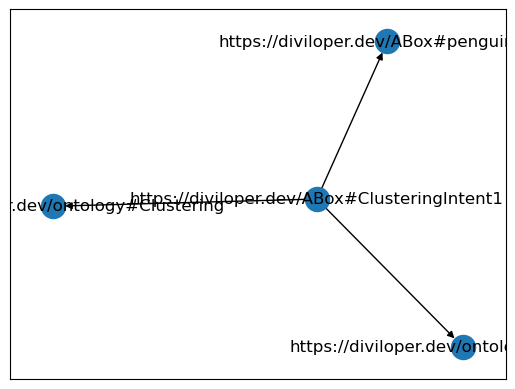

In [4]:
plot_graph(ug)

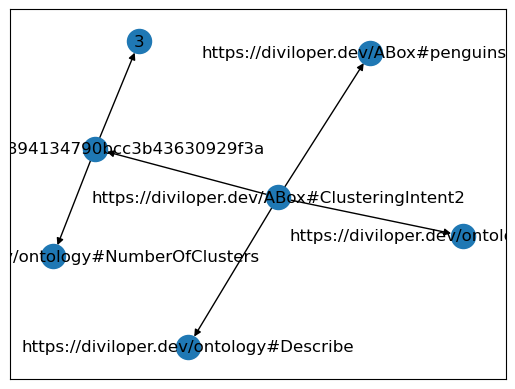

In [5]:
plot_graph(ug2)

In [17]:
# Input: graph + user intent iri
intent = ug2
user_intent = abox.ClusteringIntent2
workflow_name = 'Clustering2'

In [18]:
result = intent.query(f"""
    PREFIX do: <{do}>
    SELECT ?dataset ?problem
    WHERE {{
        <{user_intent}> a do:UserIntent .
        <{user_intent}> do:overData ?dataset .
        <{user_intent}> do:tacklesProblem ?problem .
    }}
""").bindings[0]
dataset = result['dataset']
problem = result['problem']

params = intent.query(f"""
    PREFIX do: <{do}>
    SELECT ?param ?value
    WHERE {{
        <{user_intent}> a do:UserIntent .
        <{user_intent}> do:hasParameterValue ?param_value .
        ?param_value do:forParameter ?param .
        ?param_value do:hasValue ?value .
    }}
""").bindings
print(dataset)
print(problem)
print(params)

https://diviloper.dev/ABox#penguins.csv
https://diviloper.dev/ontology#Describe
[{rdflib.term.Variable('param'): rdflib.term.URIRef('https://diviloper.dev/ontology#NumberOfClusters'), rdflib.term.Variable('value'): rdflib.term.Literal('3', datatype=rdflib.term.URIRef('http://www.w3.org/2001/XMLSchema#integer'))}]


In [19]:
dataset_loader = ontology.query(f"""
    PREFIX do: <{do}>
    PREFIX big_w: <{bigowl_workflows}>
    PREFIX big_d: <{bigowl_data}>
    SELECT ?loader ?path
    WHERE {{
        <{dataset}> do:fileFormat ?format ;
                    big_d:path ?path .
        ?loader a big_w:DataIngestion ;
                do:fileFormat ?format .
    }}
""").bindings[0]
dataset_loader

{rdflib.term.Variable('loader'): rdflib.term.URIRef('https://diviloper.dev/ontology#Import_CSV'), rdflib.term.Variable('path'): rdflib.term.Literal('C:\\Users\\Victor\\Development\\thesis\\Ontology\\dataset_annotator\\penguins.csv')}

In [20]:
params_match = [f'              big_w:hasParameter <{param["param"]}> ;' for i, param in enumerate(params)]

components = ontology.query(f"""
    PREFIX do: <{do}>
    PREFIX big_w: <{bigowl_workflows}>
    PREFIX big_p: <{bigowl_problems}>
    PREFIX big_a: <{bigowl_algorithms}>
    SELECT ?component
    WHERE {{
        ?component a big_w:Component ;
                   {''.join(params_match)}
                   big_w:hasAlgorithm ?algorithm .
        ?algorithm big_a:solves ?p .
        ?p do:subProblemOf* <{problem}> .
    }}
""").bindings
components

[{rdflib.term.Variable('component'): rdflib.term.URIRef('https://diviloper.dev/ontology#KMeansComponent')},
 {rdflib.term.Variable('component'): rdflib.term.URIRef('https://diviloper.dev/ontology#MixtureGaussianComponent')}]

In [21]:
workflows = [Graph() for _ in range(len(components))]
for i, workflow in enumerate(workflows):
    workflow.add((abox.term(workflow_name), RDF.type, bigowl_workflows.Workflow))

    load_task = abox.term(f'{workflow_name}_1')
    workflow.add((load_task, RDF.type, bigowl_workflows.Task))
    workflow.add((load_task, bigowl_workflows.hasComponent, dataset_loader['loader']))

    load_task_path = abox.term(f'{workflow_name}_1_path')
    workflow.add((load_task, do.hasParameterValue, load_task_path))
    workflow.add((load_task_path, do.forParameter, do.path))
    workflow.add((load_task_path, do.hasValue, dataset_loader['path']))

    workflow.add((abox.term(workflow_name), bigowl_workflows.hasTask, load_task))
    component = components[i]['component']
    component_task = abox.term(f'{workflow_name}_2')
    workflow.add((component_task, RDF.type, bigowl_workflows.Task))
    workflow.add((component_task, bigowl_workflows.hasComponent, component))
    workflow.add((load_task, bigowl_workflows.connectedTo, component_task))
    workflow.add((abox.term(workflow_name), bigowl_workflows.hasTask, component_task))
    for param in params:
        param_value = BNode()
        workflow.add((component_task, do.hasParameterValue, param_value))
        workflow.add((param_value, do.forParameter, param['param']))
        workflow.add((param_value, do.hasValue, param['value']))

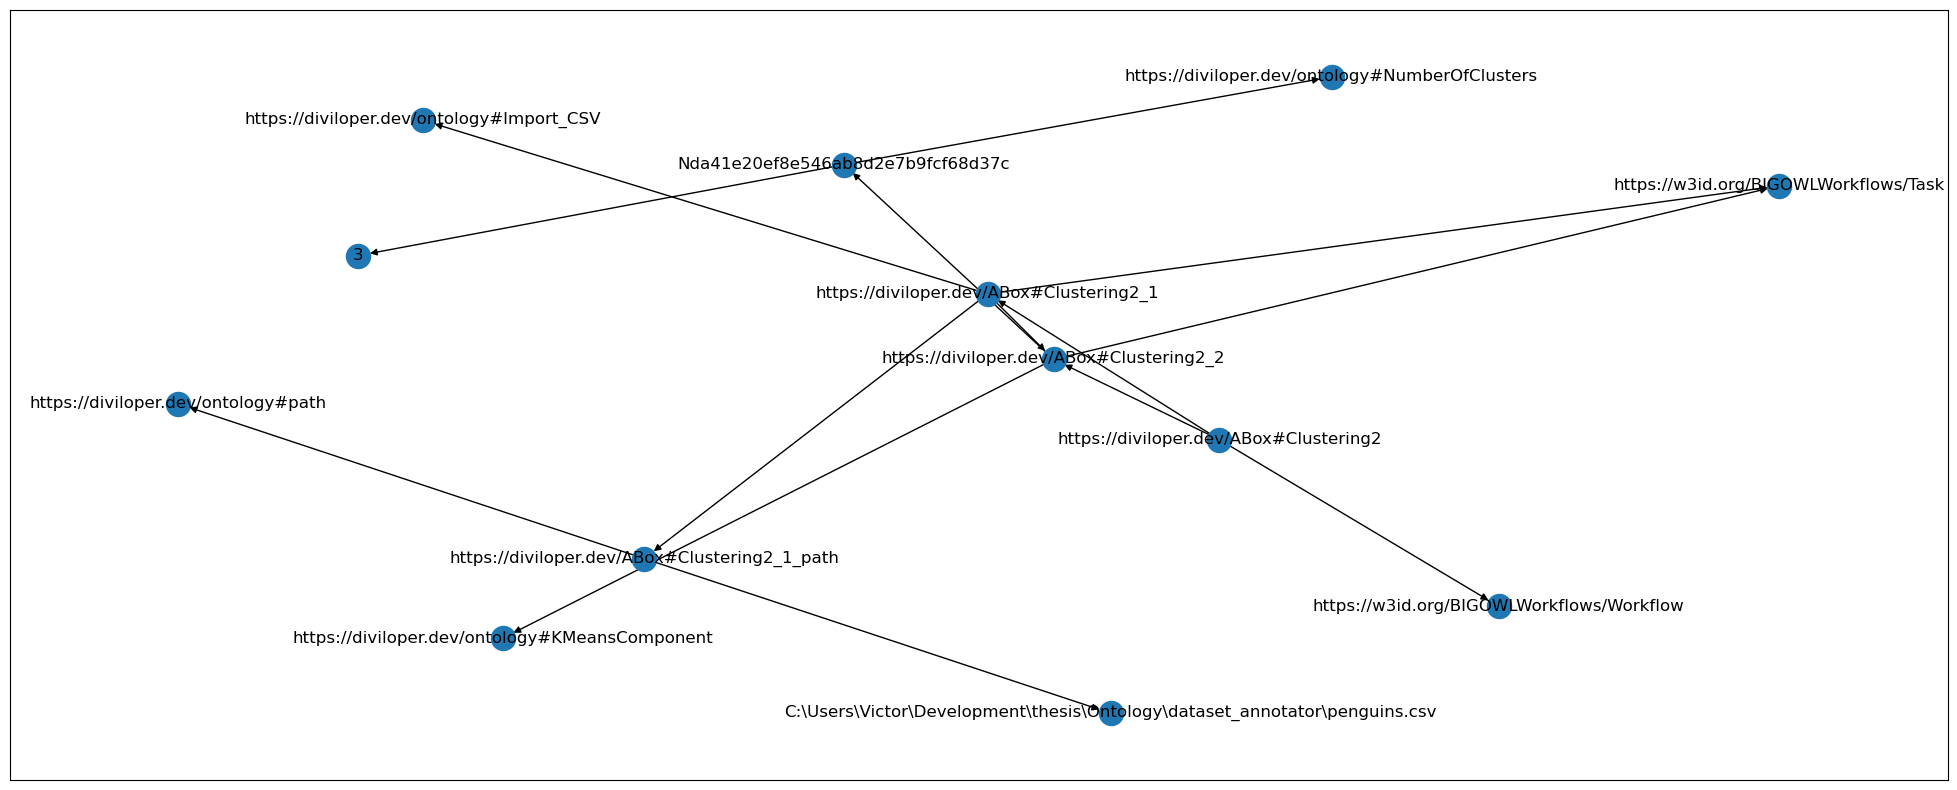

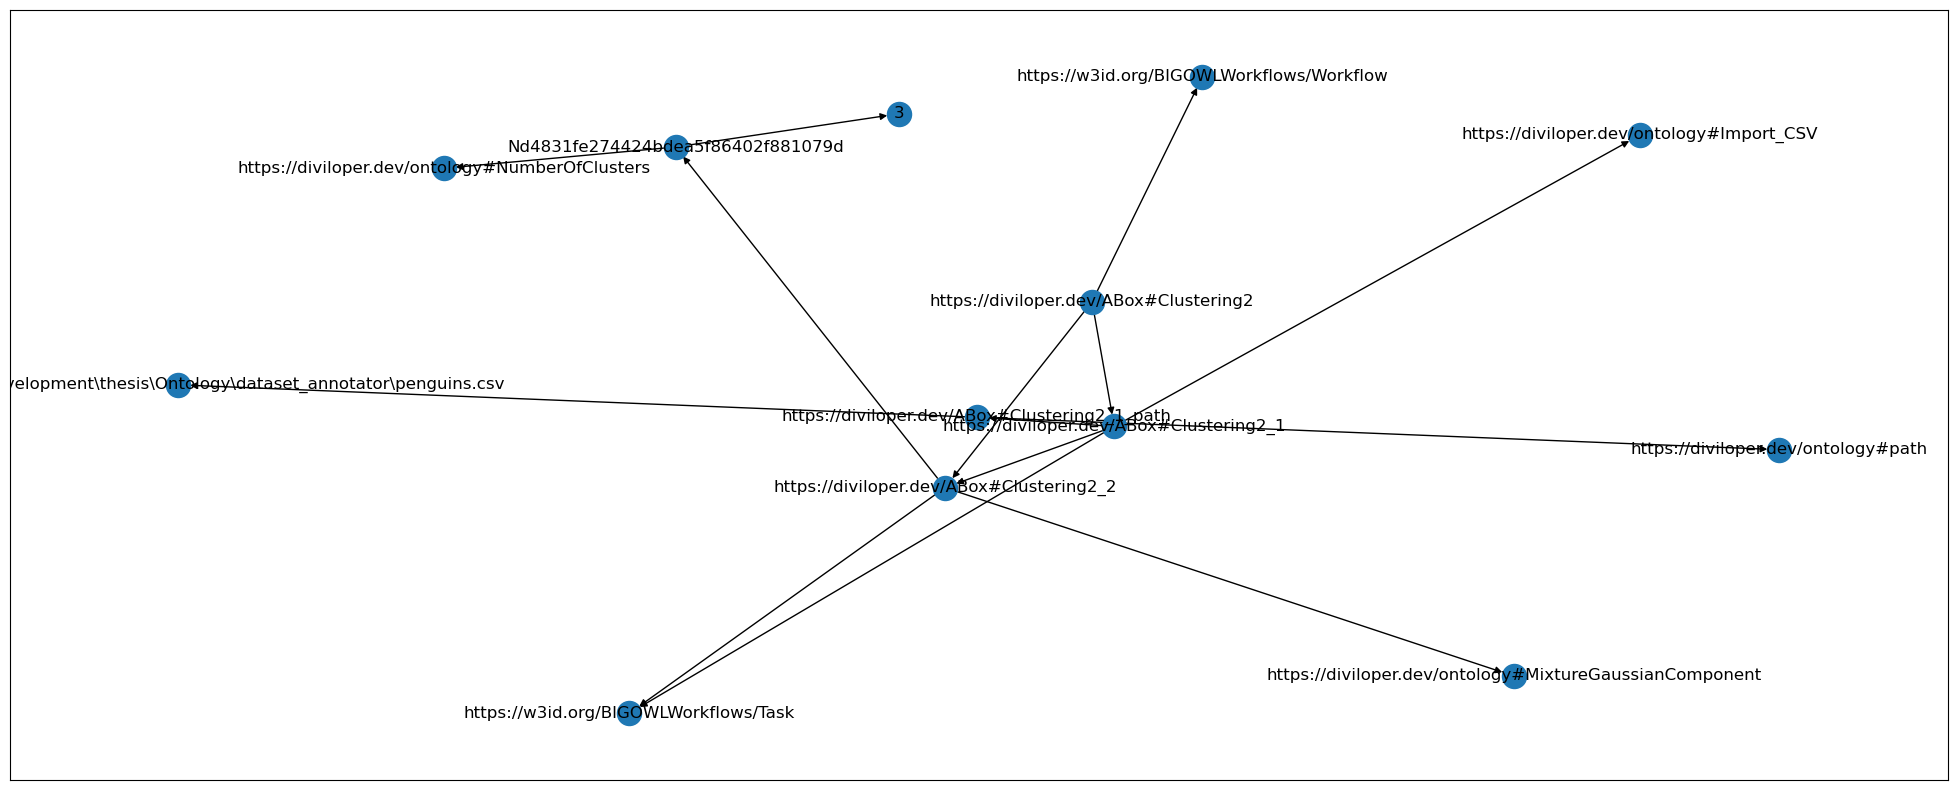

In [22]:
for wf in workflows:
    plt.figure(figsize=(25, 10))
    plot_graph(wf)

In [23]:
for i, workflow in enumerate(workflows):
    workflow.serialize(f'./{workflow_name}_{i}.ttl')
intent.serialize(f'./{workflow_name}_user_intent.ttl')

<Graph identifier=N9b8dbc10178545f384167b406c8b575c (<class 'rdflib.graph.Graph'>)>